# Imports

In [1]:
import os 
os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query
from src.data.data_statics import (
    MIN_TOKENS_SUMMARY,
    MIN_TOKENS_BODY,
    MIN_COMPRESION_RATIO,
    MAX_COMPRESION_RATIO,
    MAX_TOKENS_SUMMARY,
    SQL_WIKI_DUMP,
)

#  Constants

In [4]:
plt.rcParams["figure.figsize"] = (12.5,7.5)

# Read data

We will only consider articles which data quality is relevant to our task. 
There are over 21M articles but a lot of them are redirects or poor quality summaries, in this section, the first filtering method that we will consider will be the length of both the summary and the body as well as the compression ratio.
The levels used for this are outlined bellow.

Which means that we go from about 21M articles to ~1.4M

In [5]:
print("MIN_TOKENS_SUMMARY: ", MIN_TOKENS_SUMMARY)
print("MIN_TOKENS_BODY: ", MIN_TOKENS_BODY)
print("MAX_TOKENS_SUMMARY: ", MAX_TOKENS_SUMMARY)
print("MIN_COMPRESION_RATIO: ", MIN_COMPRESION_RATIO)
print("MAX_COMPRESION_RATIO: ", MAX_COMPRESION_RATIO)



MIN_TOKENS_SUMMARY:  40
MIN_TOKENS_BODY:  250
MAX_TOKENS_SUMMARY:  512
MIN_COMPRESION_RATIO:  0.05
MAX_COMPRESION_RATIO:  0.3


In [6]:
query = f"""
SELECT *
FROM article_level_info
WHERE body_word_count>={MIN_TOKENS_BODY} 
    AND summary_word_count>={MIN_TOKENS_SUMMARY}
    AND summary_word_count<={MAX_TOKENS_SUMMARY}
    AND CAST( summary_word_count AS FLOAT)/ CAST( body_word_count AS FLOAT) >= {MIN_COMPRESION_RATIO}
    AND CAST( summary_word_count AS FLOAT)/CAST( body_word_count AS FLOAT) <= {MAX_COMPRESION_RATIO}
"""

data = retrieve_query(query, out_f=SQL_WIKI_DUMP)

In [7]:
data = pd.DataFrame(
    data,
    columns=["pageid", "title", "summary_word_count", "body_word_count"],
)

In [8]:
print(f"Number of observations: {len(data)}")

Number of observations: 6284


# Evaluate distribution

In [9]:
data.head()

,pageid,title,summary_word_count,body_word_count
0,12,Anarchism,357,6950
1,25,Autism,398,7395
2,39,Albedo,384,2963
3,290,A,141,1914
4,309,An American in Paris,162,1765


In [10]:
data.describe()

,pageid,summary_word_count,body_word_count
count,6284.000000,6284.000000,6284.000000
mean,14226.049968,226.744749,2539.034055
std,7929.462298,123.790899,1887.701764
min,12.000000,40.000000,254.000000
25%,7323.500000,122.000000,1103.750000
50%,14131.000000,206.000000,1961.000000
75%,21259.500000,321.000000,3479.250000
max,27636.000000,512.000000,9851.000000


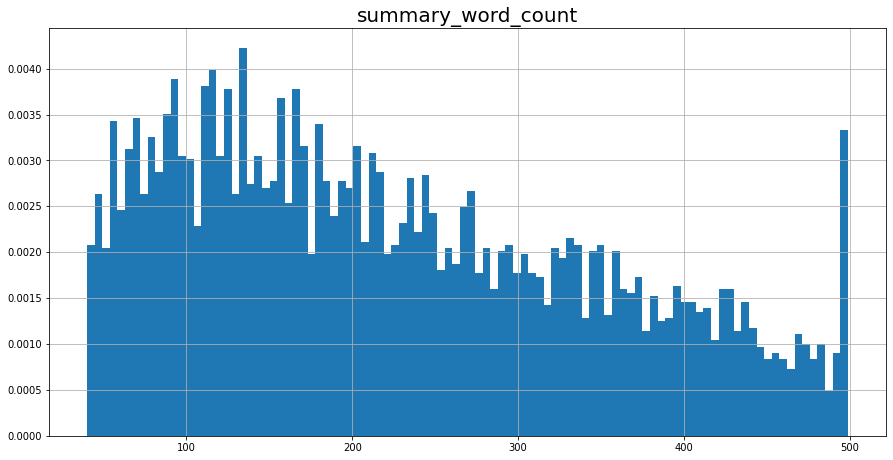

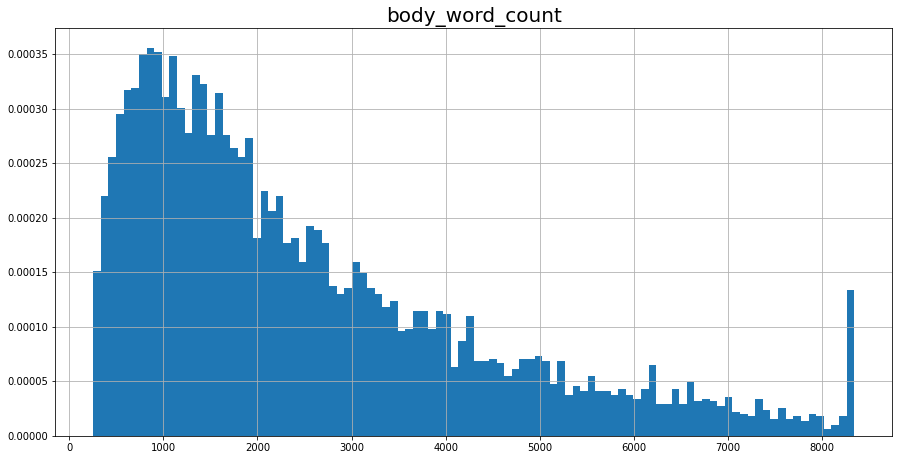

In [11]:
for var in [ "summary_word_count", "body_word_count"]:
    plt.figure(figsize = (15,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.99)
    data[var].clip(0,quantile).hist(bins = int(min(100,quantile)), density = True)
    plt.show()
    

# Ratios

In [12]:
data["tokens_ratio_summary_body"]=data["summary_word_count"]/data["body_word_count"]

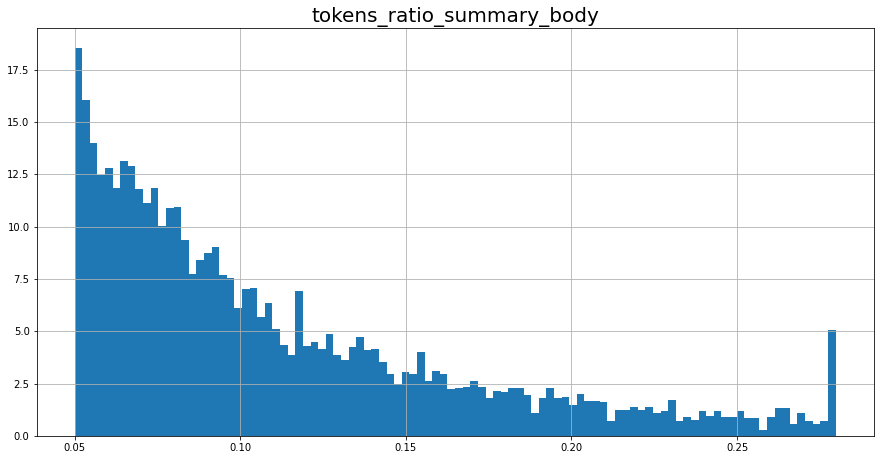

0.092710155971904


In [13]:
for var in ["tokens_ratio_summary_body"]:
    plt.figure(figsize = (15,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.99)
    data[var].clip(0,quantile).hist(bins = 100, density = True)
    plt.show()
    print(data[var].median())

# Joint plots

In [14]:
cols_to_clip = ["tokens_ratio_summary_body","summary_word_count","body_word_count"]
for var in cols_to_clip :
    quantile = data[var].quantile(0.90)
    data[var + "_clip"] = data[var].clip(0, quantile)
    

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]

    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)
    
    plt.show()

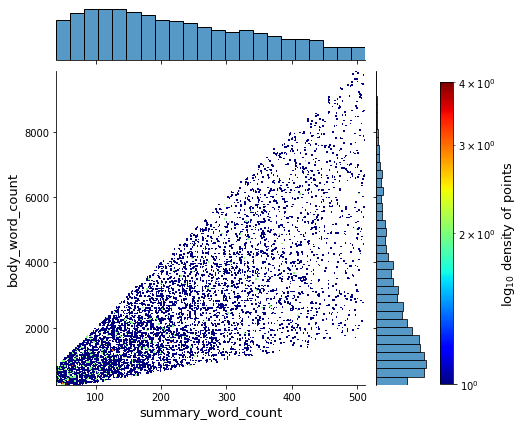

In [16]:
plot_joint(
    data,
    "summary_word_count",
    "body_word_count",
    bins=(500, 500),
)

In [17]:
query =f"""
SELECT wk.*,ar.title
FROM article_level_info ar
LEFT JOIN wiki_articles wk 
    ON ar.pageid = wk.pageid
WHERE ar.body_word_count>15 and ar.summary_word_count>150 AND ar.pageid>10000
LIMIT 20
"""

data_text = retrieve_query(query)

In [18]:
import pickle 

In [19]:
for i in data_text:
    print("-" * 100)
    pageid = i[0]
    section_title = i[1]
    summary = i[2]
    body_sections = i[3]
    section_word_count = i[4]
    title = i[5]
    
    print("pageid: ", pageid)
    print("section_title: ", pickle.loads(section_title))
    print("title: ",title)
    print("summary: ", summary)
    for sect in pickle.loads(body_sections):
        print(sect)
    print("section_word_count: ", pickle.loads(section_word_count))
    

----------------------------------------------------------------------------------------------------
pageid:  10002
section_title:  ['Family and early life', 'Education and career', 'Theories and classification schemes', 'Influence', "Dreaming for psychiatry's sake", 'Bibliography']
title:  Emil Kraepelin
summary:   

Emil Wilhelm Georg Magnus Kraepelin (; ; 15 February 1856 – 7 October 1926) was a German psychiatrist.

H. J. Eysenck's Encyclopedia of Psychology identifies him as the founder of modern scientific psychiatry, psychopharmacology and psychiatric genetics.

Kraepelin believed the chief origin of psychiatric disease to be biological and genetic malfunction. His theories dominated psychiatry at the start of the 20th century and, despite the later psychodynamic influence of Sigmund Freud and his disciples, enjoyed a revival at century's end.  While he proclaimed his own high clinical standards of gathering information by means of expert analysis of individual cases, he also dr